# 1. Jet Data

In [1]:
from multimodal_particles.utils.experiment_configs import Configs,load_config
from multimodal_particles.data.particle_clouds.jets import JetDataclass

config_path = r"/home/cesarali/Codes/multimodal_particles/configs_files/config-berlin.yaml"

config = load_config(config_path)
jets = JetDataclass(config=config)


/home/cesarali/Codes/multimodal_particles/multimodal_particles/data/particle_clouds/utils.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


In [2]:
config.__dict__

{'experiment': namespace(type='multimodal',
           experiment_name='multimodal_brige_matching',
           experiment_indentifier=None,
           experiment_dir=None),
 'data': namespace(target=namespace(name='AspenOpenJets',
                            path=['/home/cesarali/Codes/multimodal_particles/data/2016H_job0.h5'],
                            params=namespace(min_num_particles=0,
                                             max_num_particles=128,
                                             num_jets=1000),
                            preprocess=namespace(continuous='standardize',
                                                 discrete='tokens')),
           source=namespace(name='GaussNoise',
                            path=None,
                            params=namespace(scale=1.0,
                                             min_num_particles=0,
                                             max_num_particles=128,
                                             set_masks

### inspect data

In [3]:
jets.source.continuous.shape, jets.source.discrete.shape, jets.source.mask.shape

(torch.Size([1000, 128, 3]),
 torch.Size([1000, 128, 6]),
 torch.Size([1000, 128, 1]))

In [4]:
jets.target.continuous.shape, jets.target.discrete.shape, jets.target.mask.shape

(torch.Size([1000, 128, 3]),
 torch.Size([1000, 128, 6]),
 torch.Size([1000, 128, 1]))

/home/cesarali/particles/lib/python3.12/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


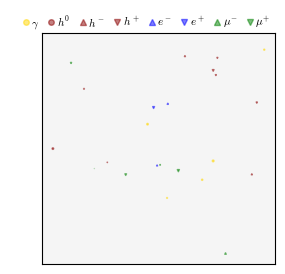

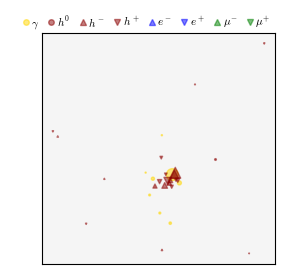

In [5]:
jets.source.display_cloud(idx=0, scale_marker=1.0)
jets.target.display_cloud(idx=0, scale_marker=1.0)

### point-cloud feature histograms

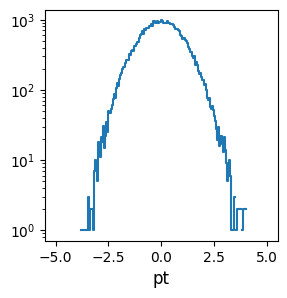

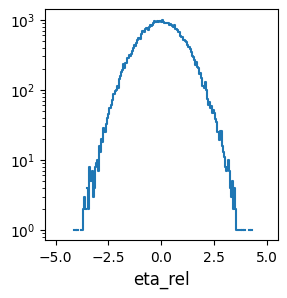

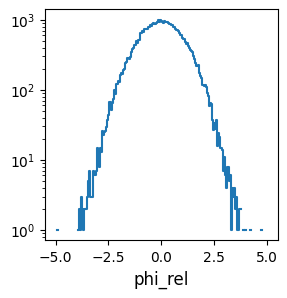

In [6]:
jets.source.histplot(
    feature="pt", fill=False, binrange=(-5, 5), binwidth=0.05, log_scale=(False, True)
)  # momentum distrbution
jets.source.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # rapidity distrbution
jets.source.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-5, 5),
    binwidth=0.05,
    log_scale=(False, True),
)  # azimutal angle distrbution


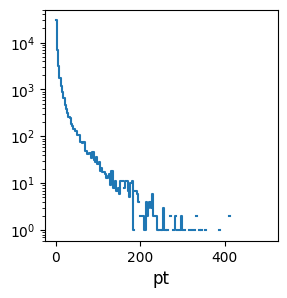

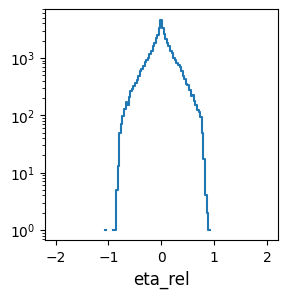

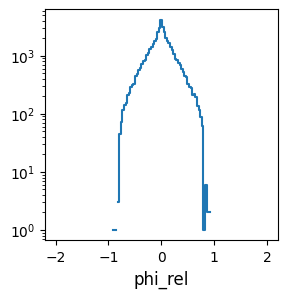

In [7]:
jets.target.histplot(
    feature="pt", fill=False, binrange=(0, 500), binwidth=3, log_scale=(False, True)
)  # momentum distrbution
jets.target.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # rapidity distribution
jets.target.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # azimuthal angle distribution

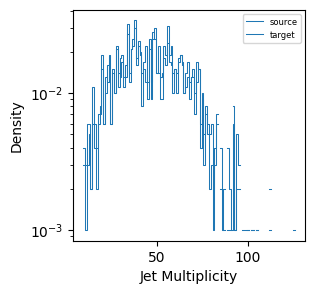

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot(
    jets.source.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="source",
)
sns.histplot(
    jets.target.multiplicity,
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, True),
    ax=ax,
    label="target",
)
ax.legend(fontsize=6)
ax.set_xlabel("Jet Multiplicity")
plt.show()

In [9]:
config.data.print()

AttributeError: 'types.SimpleNamespace' object has no attribute 'print'

# 2. Train bridge:

In [ ]:
from multimodal_particles.data.particle_clouds.dataloader import MultimodalBridgeDataloaderModule

jets.preprocess()
dataloader = MultimodalBridgeDataloaderModule(config=config, dataclass=jets)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 800, validation size: 200, testing sizes: 0


In [13]:
databatch = next(dataloader.train.__iter__())

In [ ]:
import lightning as L

from multimodal_particles.models.generative.multimodal_bridge_matching import MultiModalBridgeMatching
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)

bridge = MultiModalBridgeMatching(config)

model = L.Trainer(
    max_epochs=config.train.epochs,
    log_every_n_steps=5,
    accelerator="gpu",
    devices=[0],
    gradient_clip_val=1.0,
    callbacks=[progress_bar],
    logger=True,
)


In [ ]:
model.fit(bridge, train_dataloaders=dataloader.train, val_dataloaders=dataloader.valid)

You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder            │ MultiModalEPiC   │  827 K │ train │
│ 1 │ loss_continuous_fn │ MSELoss          │      0 │ train │
│ 2 │ loss_discrete_fn   │ CrossEntropyLoss │      0 │ train │
└───┴────────────────────┴──────────────────┴────────┴───────┘

Trainable params: 827 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 827 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 70                                                                                          
Modules in eval mode: 0

Output()